In [1031]:
import pandas as pd
import numpy as np
#import geopandas
import sqlalchemy
import seaborn as sns
from clickhouse_driver import Client
#from keplergl import KeplerGl
import plotly.express as ps
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
from plotly.subplots import make_subplots
import plotly.express as px
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import h3

In [1032]:
airbnb_ratings_new = pd.read_csv('airbnb_ratings_new.csv', encoding="CP866", low_memory=False)
LA_Listings = pd.read_csv('LA_Listings.csv', encoding="CP866", low_memory=False)
NY_Listings = pd.read_csv('NY_Listings.csv', encoding="CP866", low_memory=False)

## Решение

In [1044]:
Listings = pd.read_csv('NY_Listings.csv', encoding="CP866", low_memory=False)
Listings.dropna(axis='index', how='any')
Listings.columns

Index(['Listing ID', 'Name', 'Host ID', 'Host Name', 'Host Response Rate',
       'Host Is Superhost', 'Host total listings count', 'Street', 'City',
       'Neighbourhood cleansed', 'State', 'Country', 'latitude', 'longitude',
       'Property type', 'Room type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Amenities', 'Price', 'Minimum nights', 'Maximum nights',
       'Availability 365', 'Calendar last scraped', 'Number of reviews',
       'Last Review Date', 'Review Scores Rating', 'Review Scores Accuracy',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location',
       'Review Scores Value', 'Reviews per month'],
      dtype='object')

Подготовим данные

In [1045]:
Listings = Listings.dropna(axis='index', how='any') # удаляем объявления с пропусками в данных
Listings = Listings[Listings['Review Scores Rating'] != 0] # удаляем объявления без оценок
Listings = Listings[Listings['Review Scores Rating'] <= 100] # удаляем выбросы
Listings = Listings[Listings['Number of reviews'] > 1] # удаляем объявления без отзывов

In [1046]:
data1 = Listings[Listings['Host Is Superhost'] == 0] # обычные пользователи
data2 = Listings[Listings['Host Is Superhost'] == 1] # суперхосты

Посмотрим на рейтинги отзывов суперхостов и обычных пользователей

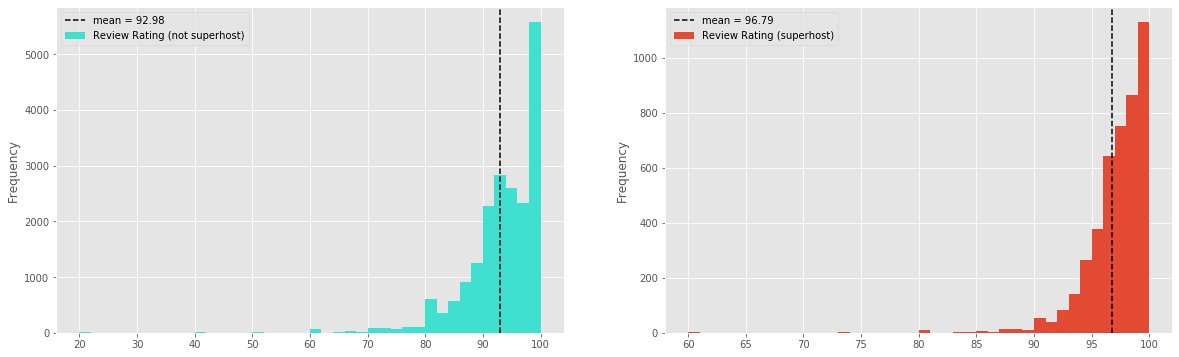

In [1047]:
plt.figure(figsize=(20,6))

plt.subplot(1, 2, 1)
m1 = data1['Review Scores Rating'].mean();
plt.axvline(m1, color='k', linestyle='dashed', label = 'mean = ' + str(round(m1, 2)))
data1['Review Scores Rating'].plot.hist(grid=True, bins=40, rwidth=10, color='turquoise', label = 'Review Rating (not superhost)')
plt.legend()

plt.subplot(1, 2, 2)
m2 = data2['Review Scores Rating'].mean()
plt.axvline(m2, color='k', linestyle='dashed', label = 'mean = ' + str(round(m2, 2)))
data2['Review Scores Rating'].plot.hist(grid=True, bins=40, rwidth=10, label = 'Review Rating (superhost)')
plt.legend()

plt.show()

## Гипотеза 1 

Статус суперхоста дает приемущество при сдаче квартиры на AirB&b. Следовательно, клиенты, имеющие такой статус, заинтересованны продолжать работать с нами.
Будем стимулировать обычных пользователей с большим рейтингом (потенциальных суперхостов), а также суерхостов с низким рейтингом пользоваться нашими услугами. 

In [1048]:
result = pd.concat([data1, data2])

Выбираем интересующие нас данные, которые влияют на потенциальную "доходность" клиента:

In [1049]:
data = pd.DataFrame()

data['listing_id'] = result['Listing ID']
data['host_id'] = result['Host ID']
data['superhost'] = result['Host Is Superhost']
data['availability'] = result['Availability 365']
data['price'] = result['Price']
data['min_nights'] = result['Minimum nights']
data['reviews_per_month'] = result['Reviews per month']

data['last_rewiew'] = result['Last Review Date']

Вычислим количество дней, которое прошло со времени написания последнего отзыва

In [1050]:
data['last_rewiew'] = pd.to_datetime(data['last_rewiew'].str.split('/').str.join('-')) # делаем dd-mm-yyyy

max_date = data['last_rewiew'].max()
data['last_rewiew'] = (max_date - data['last_rewiew']).dt.days # считаем, что последний отзыв написали сегодня

## Occupancy

Вычислим "занятость" сдаваемого объекта: occupancy = ((reviews per month * min. nights) * 12) / availability_365

In [1051]:
data['occupancy'] = (data['reviews_per_month'] * data['min_nights'] * 12) / data['availability']

Ограничим это значение сверху единицей (что логично)

In [1052]:
data = data.replace(np.inf, 1) # для квартир, занятых все дни в году
data['occupancy'] = np.where(data['occupancy'] > 1, 1, data['occupancy']) # слишком большое кол-во отзывов

Удаляем ненужное

In [1053]:
data = data.drop(['reviews_per_month'],axis = 1)
data = data.drop(['min_nights'],axis = 1)
data = data.drop(['availability'],axis = 1)

Посмотрим на наш датасет:

In [977]:
data.head()

,listing_id,host_id,superhost,price,last_rewiew,occupancy
7,17545953,74732009,False,135,41,0.091948
9,10513135,47987624,False,56,7,0.909000
13,4432082,22994518,False,45,61,0.035604
15,16578740,74732009,False,115,83,0.041770
18,15146736,49559491,False,65,24,0.013479


## RFM-анализ

In [978]:
def RScore(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1
    
def FMScore(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 4
    else:
        return 5

In [979]:
quantiles = data.quantile(q=[0.2,0.4,0.6,0.8]).to_dict()
quantiles

{'listing_id': {0.2: 4033738.1999999997,
  0.4: 8367470.0,
  0.6: 12901418.0,
  0.8: 15546050.200000001},
 'host_id': {0.2: 4460269.400000002,
  0.4: 13716757.0,
  0.6: 30799561.599999994,
  0.8: 59521112.000000015},
 'superhost': {0.2: 0.0, 0.4: 0.0, 0.6: 0.0, 0.8: 1.0},
 'price': {0.2: 60.0, 0.4: 89.0, 0.6: 120.0, 0.8: 180.0},
 'last_rewiew': {0.2: 8.0, 0.4: 17.0, 0.6: 32.0, 0.8: 101.0},
 'occupancy': {0.2: 0.05665168539325843,
  0.4: 0.1342487646777536,
  0.6: 0.2633132990750257,
  0.8: 0.6729122807017553}}

In [980]:
data['r_quartile'] = data['last_rewiew'].apply(RScore, args=('last_rewiew',quantiles,))
data['f_quartile'] = data['occupancy'].apply(FMScore, args=('occupancy',quantiles,))
data['m_quartile'] = data['price'].apply(FMScore, args=('price',quantiles,))

In [981]:
data['RFM_Score'] = data['r_quartile'] + data['f_quartile'] + data['m_quartile']
data = data.drop(['r_quartile'],axis = 1)
data = data.drop(['f_quartile'],axis = 1)
data = data.drop(['m_quartile'],axis = 1)
data = data.drop(['last_rewiew'],axis = 1)
data = data.drop(['occupancy'],axis = 1)
data = data.drop(['price'],axis = 1)
data

,listing_id,host_id,superhost,RFM_Score
7,17545953,74732009,False,8
9,10513135,47987624,False,11
13,4432082,22994518,False,4
15,16578740,74732009,False,6
18,15146736,49559491,False,6
...,...,...,...,...
31120,7026362,31622133,True,4
31130,4251124,22060067,True,8
31135,7182074,37059770,True,7
31137,10920578,1381694,True,7


Посмотрим, на результаты анализа:

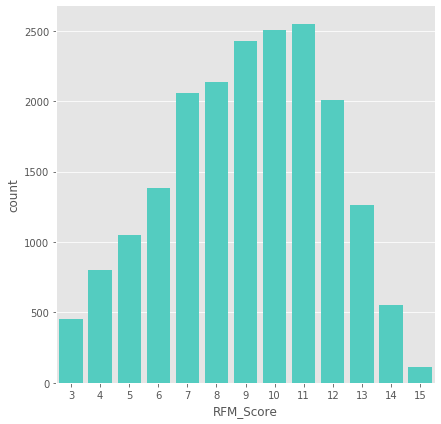

In [982]:
sns.catplot(x="RFM_Score", kind="count",color='turquoise', data=data, height = 6)

Предоставим скидку клиентам, имеющим RFM_Score сдаваемого объекта больше 11

In [998]:
id_discont = data[data['RFM_Score'] > 11]['host_id']

In [999]:
len(id_discont) # всего объектов, имеющих RFM_Score > 11

3945

In [1001]:
id_discont.nunique() # всего клиентов получили скидку

3055

In [1002]:
All_Listings = pd.read_csv('LA_Listings.csv', encoding="CP866", low_memory=False)

In [1003]:
id_discont.nunique() / All_Listings['Host ID'].nunique()

0.08764380181885992